# Imports

In [ ]:
!pip install shap
!pip install catboost
!jupyter nbextension enable --py widgetsnbextension
!pip install --user --upgrade ipywidgets

In [89]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, classification_report, roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold
from catboost import CatBoostClassifier, Pool, cv
from sklearn.feature_selection import SelectKBest, chi2
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
pd.set_option('max_colwidth', 500)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [90]:
pd.set_option('precision', 0)

In [130]:
# Load files into a pandas dataframe
train = pd.read_csv('../input/autoinland/Train (1).csv')
test = pd.read_csv('../input/autoinland/Test (1).csv')
s = pd.read_csv('../input/autoinland-insurance/SampleSubmission.csv')

# EDA

In [131]:
train = train.fillna(-9999)
test = test.fillna(-9999)


# Combine train and test

In [132]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (17256, 14)


In [133]:
# Change each column to its appriopriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
 # elif col in cat_cols:
  #  all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
#all_data.info()

# Feature creation

In [135]:
all_data['start year'] = all_data['Policy Start Date'].apply(lambda x: x.year)
all_data['start month'] = all_data['Policy Start Date'].apply(lambda x: x.month)
all_data['start Day'] = all_data['Policy Start Date'].apply(lambda x: x.day)

In [136]:
all_data['End year'] = all_data['Policy End Date'].apply(lambda x: x.year)
all_data['End month'] = all_data['Policy End Date'].apply(lambda x: x.month)
all_data['End Day'] = all_data['Policy End Date'].apply(lambda x: x.day)

In [137]:
all_data['transaction duration'] = all_data['Policy End Date'] - all_data['Policy Start Date']
#all_data['transaction duration'].replace({'days',''})
all_data['transaction duration'] = all_data['transaction duration'].dt.days

In [138]:
all_data['End weekday'] = all_data['Policy End Date'].apply(lambda x: x.weekday())
all_data['start weekday'] = all_data['Policy Start Date'].apply(lambda x: x.weekday())

# Means of numeric columns

In [141]:
all_data[['mean Policy Start Date', 'mean Policy End Date', 'mean Age', 'mean First Transaction Date',
       'mean No_Pol', 'mean target', 'mean start year', 'mean start month', 'mean start Day',
       'mean End year', 'mean End month', 'mean End Day', 'mean transaction duration',
       'mean End weekday', 'mean start weekday']] =  all_data.groupby(['Gender',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'LGA_Name',
 'State',
 'ProductName']).transform(np.mean)

# Maximums for numeric columns

In [145]:
column = [ 'Policy Start Date', 'Policy End Date', 'Age',
       'First Transaction Date', 'No_Pol', 'target', 'start year', 'start month', 'start Day',
       'End year', 'End month', 'End Day', 'transaction duration',
       'End weekday', 'start weekday']

In [147]:
all_data[['max Policy Start Date', 'max Policy End Date', 'max Age', 'max First Transaction Date',
       'max No_Pol', 'max target', 'max start year', 'max start month', 'max start Day',
       'max End year', 'max End month', 'max End Day', 'max transaction duration',
       'max End weekday', 'max start weekday']] =  all_data.groupby(['Gender',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'LGA_Name',
 'State',
 'ProductName'])[column].transform(np.max)

# Minimums for numeric columns

In [148]:
all_data[['min Policy Start Date', 'min Policy End Date', 'min Age', 'min First Transaction Date',
       'min No_Pol', 'min target', 'min start year', 'min start month', 'min start Day',
       'min End year', 'min End month', 'min End Day', 'min transaction duration',
       'min End weekday', 'min start weekday']] =  all_data.groupby(['Gender',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'LGA_Name',
 'State',
 'ProductName'])[column].transform(np.min)

## KMeans on age

In [149]:
from sklearn.cluster import KMeans

In [150]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    train_new = train.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    train_new = train_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    train_new['index'] = train_new.index
    train_final = pd.merge(train,train_new[[cluster_field_name,'index']], on=cluster_field_name)
    train_final = train_final.drop([cluster_field_name],axis=1)
    train_final = train_final.rename(columns={"index":cluster_field_name})
    return train_final

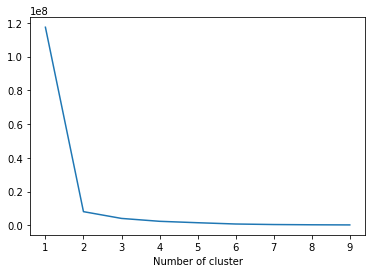

In [151]:
sse={}
all_data_cluster = all_data[['Age']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(all_data_cluster)
    all_data_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [152]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(all_data[['Age']])
all_data['Age clusters'] = kmeans.predict(all_data[['Age']])

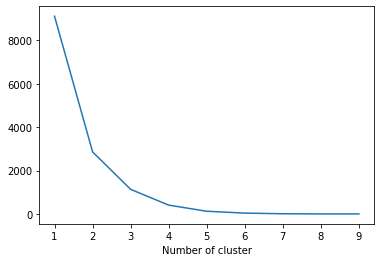

In [153]:
sse={}
all_data_cluster = all_data[['No_Pol']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(all_data_cluster)
    all_data_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

# KMeans on the number of policies

In [154]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(all_data[['No_Pol']])
all_data['No_pol clusters'] = kmeans.predict(all_data[['No_Pol']])

In [155]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts()

Male      10888
Female     4735
Other      1118
-9999       515
Name: Gender, dtype: int64

# Outlier detection 

In [ ]:
def find_boundaries(df, variable, distance):
  IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
  lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
  upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
  return upper_boundary, lower_boundary

In [ ]:
def winsorize(df, variable, upper_limit, lower_limit):
  return np.where(df[variable] > upper_limit, upper_limit,
  np.where(df[variable] < lower_limit, lower_limit,
  df[variable]))

In [ ]:
age_upper_limit, age_lower_limit = find_boundaries(all_data, 'Age', 3.2)

In [ ]:
age_upper_limit

In [ ]:
age_lower_limit

In [ ]:
all_data['Age'] = winsorize(all_data, 'Age', 100, 0) 

# EDA part 2

<AxesSubplot:>

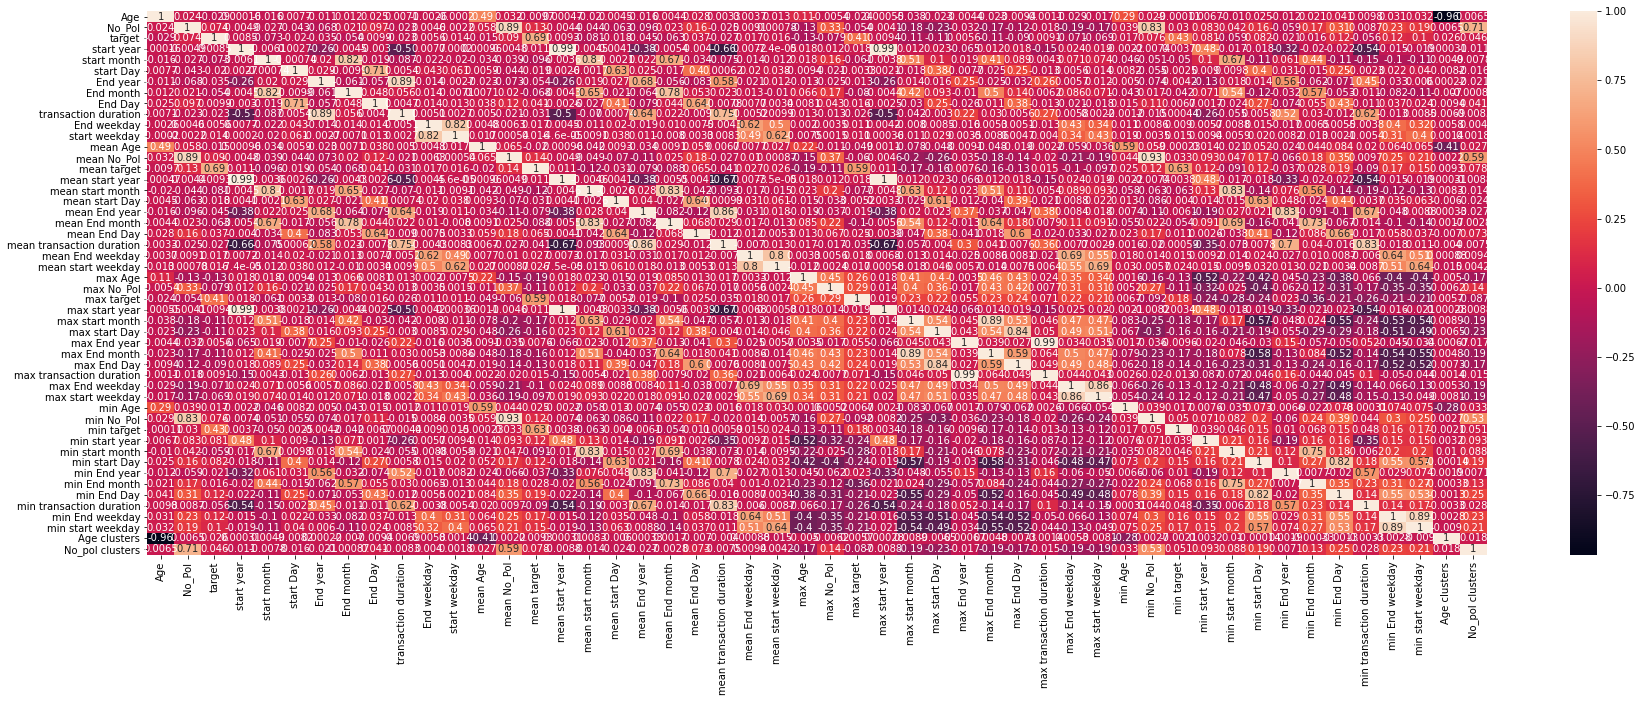

In [157]:
plt.figure(figsize=(30,10))
sns.heatmap(all_data.corr(), annot=True)

In [158]:
le = LabelEncoder()

for column in all_data.columns:
    if all_data[column].dtype == 'object' and column != 'ID':
      all_data[column] = le.fit_transform(all_data[column].astype(str)) 
       

In [159]:
all_data = all_data.fillna(-9999)

In [198]:
all_data = all_data.drop([ 'max start weekday', 'max No_Pol', 'max End month',
       'min start weekday', 'start month', 'max start month',
       'min End Day', 'mean start month', 'min Age', 'min End weekday'],axis=1)

In [199]:
# Separate train and test data from the combined dataframe
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]
test_df.drop('target', axis=1, inplace=True)
# Check the shapes of the split dataset
train_df.shape, test_df.shape

((12079, 60), (5177, 59))

In [200]:
# Change each column to its appriopriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]


In [201]:
main_cols = train_df.columns.difference(date_cols+['ID', 'target','mean target','min target','max target'])
X = train_df[main_cols]
y = train_df.target.astype(int)


In [202]:
X.shape

(12079, 43)

In [203]:
 all_data[main_cols] = all_data[main_cols].applymap(np.int64)

In [204]:
#cross validation
n_skf=12
kf=StratifiedKFold(n_skf)
seed=2020


# Imblearn over

In [205]:
X = X.applymap(np.int64)

In [206]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

#print(X_ros.shape[0] - X.shape[0], 'new random picked points')
#plot_2d_space(X_ros, y_ros, 'Random over-sampling')

In [207]:
np.where(X.columns)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),)

In [208]:
categorical_features_indices =[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]

In [209]:

# Split data into train and test sets
X_train, xval, y_train, yval = train_test_split(X_ros,y_ros,test_size=0.2, random_state=42)


In [ ]:
score_list = []
score = 0
test_oofs = []

#multiple iterations with stratified kfold
for i, (tr_idx, vr_idx) in enumerate(kf.split(X,y)):
    #X_train, y_train = X.loc[tr_idx, main_cols], y.loc[tr_idx]
    #xval, yval = X.loc[vr_idx, main_cols], y.loc[vr_idx]
    
    params = {
    'loss_function': 'CrossEntropy',# objective function
   # 'loss_function' :'Logloss',
    'iterations': 10000,
   # 'custom_loss': 'F1',
    'learning_rate': 0.01,
    'cat_features' : categorical_features_indices,
    'eval_metric':'F1', # metric,
    #'task_type':'GPU',
    #'border_count':32,
    'early_stopping_rounds':200,
    'verbose': 200, # output to stdout info about training process every 200 iterations
   # 'random_seed': SEED
    
}

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
          eval_set=(xval,yval), # data to validate on
          use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
          plot=True # True for visualization of the training process (it is not shown in a published kernel - try executing this code)
         );
    #model fitting 
   # model=LGBMClassifier(categorical_feature =categorical_features_indices, num_leaves=25,max_depth=14,reg_alpha=1,reg_lambda=2,subsample=0.7,subsample_freq=1,colsample_bytree=0.3,n_estimators=10000,learning_rate=0.005)
    #model.fit(X_train, y_train, eval_set=[(xval,yval)],early_stopping_rounds=300, verbose=100,eval_metric='f1')
    
    #model prediction
    p = model.predict(xval)
    sc = f1_score(yval, p)
    score_list.append(sc)
    score += sc/n_skf
    
    #prediction on test data
    pred=model.predict_proba(test_df[main_cols])[:,1]

    #append last prediction to the test_oof empty list
    test_oofs.append(pred)
    
    print('Fold {} : {}'.format(i, sc))
    
print()
print()
print('Avg log :',score)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7729510	test: 0.7648962	best: 0.7648962 (0)	total: 77.9ms	remaining: 12m 58s
200:	learn: 0.9141991	test: 0.9545872	best: 0.9545872 (194)	total: 12.1s	remaining: 9m 50s
400:	learn: 0.9230321	test: 0.9595402	best: 0.9597609 (386)	total: 25.1s	remaining: 10m
600:	learn: 0.9280559	test: 0.9627415	best: 0.9627415 (569)	total: 38.3s	remaining: 9m 58s
800:	learn: 0.9301757	test: 0.9636447	best: 0.9636447 (756)	total: 51.3s	remaining: 9m 49s
1000:	learn: 0.9309582	test: 0.9645325	best: 0.9647547 (859)	total: 1m 4s	remaining: 9m 41s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9647546648
bestIteration = 859

Shrink model to first 860 iterations.
Fold 0 : 0.9647546648237733


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7729510	test: 0.7648962	best: 0.7648962 (0)	total: 68.5ms	remaining: 11m 25s
200:	learn: 0.9141991	test: 0.9545872	best: 0.9545872 (194)	total: 12s	remaining: 9m 45s
400:	learn: 0.9230321	test: 0.9595402	best: 0.9597609 (386)	total: 25.1s	remaining: 10m
600:	learn: 0.9280559	test: 0.9627415	best: 0.9627415 (569)	total: 37.9s	remaining: 9m 53s
800:	learn: 0.9301757	test: 0.9636447	best: 0.9636447 (756)	total: 51.4s	remaining: 9m 50s
1000:	learn: 0.9309582	test: 0.9645325	best: 0.9647547 (859)	total: 1m 3s	remaining: 9m 32s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9647546648
bestIteration = 859

Shrink model to first 860 iterations.
Fold 1 : 0.9647546648237733


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7729510	test: 0.7648962	best: 0.7648962 (0)	total: 83.9ms	remaining: 13m 59s
200:	learn: 0.9141991	test: 0.9545872	best: 0.9545872 (194)	total: 12s	remaining: 9m 46s
400:	learn: 0.9230321	test: 0.9595402	best: 0.9597609 (386)	total: 25.4s	remaining: 10m 7s
600:	learn: 0.9280559	test: 0.9627415	best: 0.9627415 (569)	total: 37.9s	remaining: 9m 52s
800:	learn: 0.9301757	test: 0.9636447	best: 0.9636447 (756)	total: 50.9s	remaining: 9m 44s
1000:	learn: 0.9309582	test: 0.9645325	best: 0.9647547 (859)	total: 1m 3s	remaining: 9m 27s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9647546648
bestIteration = 859

Shrink model to first 860 iterations.
Fold 2 : 0.9647546648237733


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7729510	test: 0.7648962	best: 0.7648962 (0)	total: 88.2ms	remaining: 14m 41s
200:	learn: 0.9141991	test: 0.9545872	best: 0.9545872 (194)	total: 13.6s	remaining: 11m 2s
400:	learn: 0.9230321	test: 0.9595402	best: 0.9597609 (386)	total: 26.1s	remaining: 10m 23s
600:	learn: 0.9280559	test: 0.9627415	best: 0.9627415 (569)	total: 38.3s	remaining: 9m 59s
800:	learn: 0.9301757	test: 0.9636447	best: 0.9636447 (756)	total: 51.7s	remaining: 9m 53s
1000:	learn: 0.9309582	test: 0.9645325	best: 0.9647547 (859)	total: 1m 4s	remaining: 9m 40s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9647546648
bestIteration = 859

Shrink model to first 860 iterations.
Fold 3 : 0.9647546648237733


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7729510	test: 0.7648962	best: 0.7648962 (0)	total: 69.1ms	remaining: 11m 31s
200:	learn: 0.9141991	test: 0.9545872	best: 0.9545872 (194)	total: 12.6s	remaining: 10m 14s
400:	learn: 0.9230321	test: 0.9595402	best: 0.9597609 (386)	total: 25s	remaining: 9m 57s


# Creating Submission File

In [181]:
submission_df = pd.DataFrame()
submission_df["ID"] = test["ID"]

In [182]:
submission_df["target"] = np.mean(test_oofs, axis=0).round(0).astype(int)
submission_df.to_csv("all descriptiptive features.csv", index=False)

In [180]:
submission_df

ID  target
0     ID_009D84L       1
1     ID_01DO2EQ       1
2     ID_01QM0NU       0
3     ID_024NJLZ       0
4     ID_02BYET3       1
...          ...     ...
5172  ID_ZYXX5AF       0
5173  ID_ZYYOZ5L       0
5174  ID_ZZ1GTKD       0
5175  ID_ZZDXQSI       1
5176  ID_ZZYTLV1       0

[5177 rows x 2 columns]

# Feature selection

In [183]:
np.array(model.get_feature_importance(prettified=True))

array([['ProductName', 21.34855487747874],
       ['Age', 18.2688712314799],
       ['End Day', 14.639369336058197],
       ['LGA_Name', 9.163259794289072],
       ['Subject_Car_Make', 9.111853271852295],
       ['Subject_Car_Colour', 6.284997585982137],
       ['End month', 4.241039745208226],
       ['End weekday', 2.078744852469757],
       ['Car_Category', 1.9568931178098126],
       ['State', 1.3846616093911133],
       ['Gender', 1.3696817122094307],
       ['No_pol clusters', 1.084358474240044],
       ['No_Pol', 1.053216969821325],
       ['mean start month', 0.847792625407573],
       ['End year', 0.7752638501631893],
       ['mean Age', 0.5817873709674578],
       ['min transaction duration', 0.5416347556829836],
       ['min Age', 0.539705055688931],
       ['max Age', 0.5390539277806936],
       ['min start month', 0.5102395691873853],
       ['min End month', 0.4106884579471475],
       ['start month', 0.32918821940091325],
       ['start Day', 0.2865019734324012],
       

In [188]:
train_pool = Pool(
    data=X_train, 
    label=y_train, 
    cat_features=categorical_features_indices
)


In [193]:
 m = np.array(model.get_feature_importance(
    data=train_pool, 
    type='LossFunctionChange', 
    prettified=True
))

In [196]:
#m[:,0]

In [197]:
m = pd.DataFrame(m)
#m

In [ ]:
X = 